# Variational Quantum Eigensolver using classical optimisers
### Estimation of ground state energy, Hamiltonian Hydrogen $H_{2}$

In [1]:
#Import libraries
import torch
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
import numpy as np
from math import pi
import matplotlib.pylab as plt
from itertools import product
from qiskit.quantum_info import Operator
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(1, '../src/')
from utils.functions import *
from models.models_rl import *

from scipy.linalg import eigh
from qiskit_algorithms.optimizers import SPSA, COBYLA, L_BFGS_B
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import PolynomialTensor
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import TwoLocal


In [2]:
#Setting up the H2 molecule
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)

problem = driver.run()

#Obtaining the Hamiltonian
hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()

#Converting to qubit Hamiltonian
mapper = JordanWignerMapper()
H = mapper.map(second_q_op)


nuclear_repulsion_energy = hamiltonian.nuclear_repulsion_energy
hamiltonian.electronic_integrals.alpha += PolynomialTensor({"": nuclear_repulsion_energy})
mapper = JordanWignerMapper()
second_q_op = hamiltonian.second_q_op()
H = mapper.map(second_q_op)


Initial state: Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))
Initial Circuit Ansatz


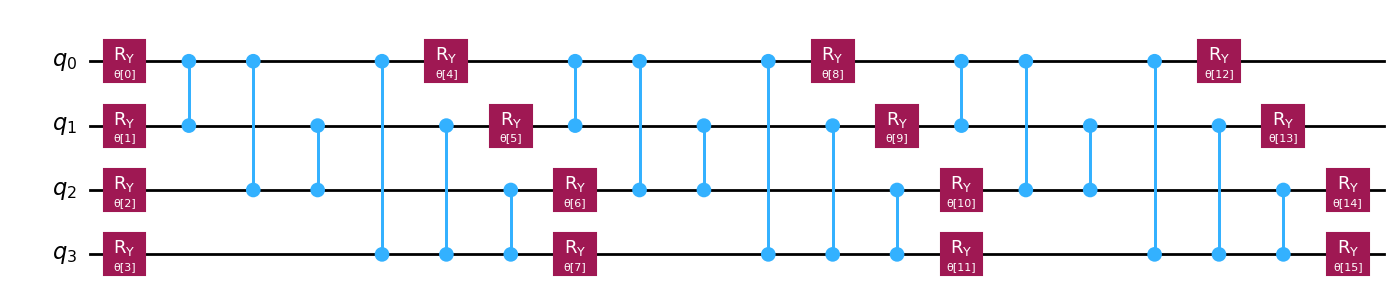

In [3]:
# Set up the initial state and, the UCCSD or TwoLocal ansatz for H2
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles
mapper = JordanWignerMapper()

initial_state = HartreeFock(
    num_spatial_orbitals,
    num_particles,
    mapper
)


ansatz = UCCSD(
    num_spatial_orbitals=num_spatial_orbitals,
    num_particles=num_particles,
    qubit_mapper=mapper,
    initial_state=initial_state
    )

ansatz = TwoLocal(H.num_qubits, rotation_blocks="ry", entanglement_blocks="cz")
num_qubits = ansatz.num_qubits

print('Initial state:',Statevector.from_instruction(initial_state))
initial_circuit = ansatz.decompose()
print('Initial Circuit Ansatz')
initial_circuit.draw('mpl')

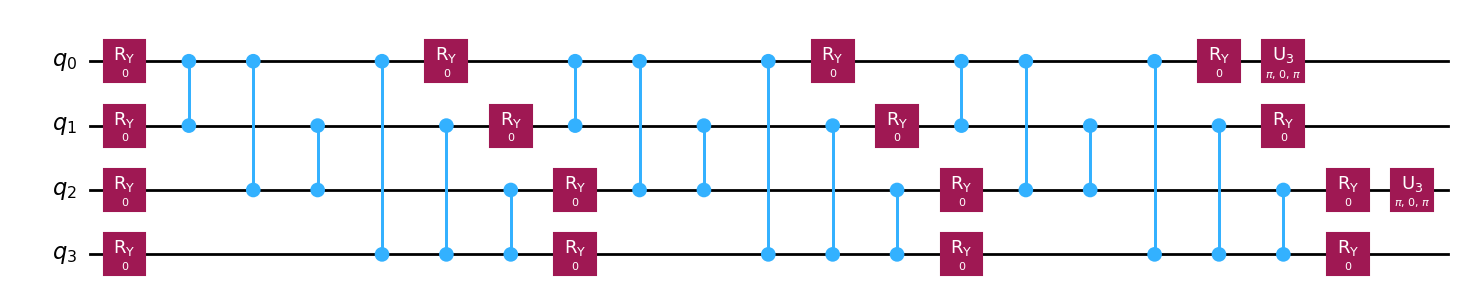

In [4]:
def create_circuit_ansatz(thetas, initial_state):

    # Create circuit
    circ = QuantumCircuit(ansatz.num_qubits)
    # Apply the initial state (HartreeFock)
    circ.compose(initial_state, inplace=True)
    # Apply the UCCSD ansatz with the generated parameters
    circ = ansatz.assign_parameters(thetas.squeeze()).compose(circ)
    return circ


n_thetas = ansatz.num_parameters
circ_visualization = create_circuit_ansatz(np.zeros(n_thetas)[np.newaxis,:], initial_state)
circ_visualization.decompose().draw('mpl')

In [5]:
def target_function(thetas):
    circuit = create_circuit_ansatz
    new_exp_values, new_eigenvalue = get_expectation_values_hamiltonian(circuit, np.array(thetas)[np.newaxis,:], initial_state, H)
    return -new_eigenvalue  

In [6]:
#Estimate the ground state energy
eigenvalues, eigenvectors = eigh(H.to_matrix())
ground_state_energy = np.min(eigenvalues)
ground_state = eigenvectors[:, np.argmin(eigenvalues)]
print(f"Ground state energy: {ground_state_energy}")

Ground state energy: -1.1373060357533995


We set up our experiment, and calculate metrics of interest.


In [7]:
n_run = 5
n_total_timesteps = 200

params = {'lr': 0.000001,
          'n_steps': 20,
          'batch_size':10,
          'gae_lambda': 0.95,
          'gamma':0.99,  
          'ent_coef':0.01,
          'clip_range':0.3,
          'n_run':n_run,
          'n_total_timesteps': n_total_timesteps,
          'n_epochs': 20
          }

metrics = {
    'best_eigenvalue_runs': np.zeros(n_run),
    'history_best_eigenvalue_runs': np.zeros((n_run, n_total_timesteps)),
    'value_losses_runs':np.zeros((n_run,n_total_timesteps)),
    'best_thetas_runs': np.zeros((n_run,n_thetas)),
    }

for iter_run in range(n_run):

    best_eigenvalue, eigenvalue_history = float('inf'), []
    best_thetas, thetas_history = np.zeros(n_thetas), []
    X_train, y_train = [], []
    
    print('run',iter_run+1)
    # Create the environment
    env = DummyVecEnv([lambda: OptimizationEnv(target_function, n_thetas)])
    metrics_callback = MetricsCallback()
    
    # Create the model
    model = PPO(
        CustomActorCriticPolicy, 
        env,
        verbose=1,
        learning_rate=params['lr'],  # Default learning rate; can be tuned further
        n_steps=params['n_steps'],  # Number of steps to run for each environment per update
        batch_size=params['batch_size'],  # Minibatch size for each gradient update
        gae_lambda=params['gae_lambda'],  # Lambda for GAE
        gamma=params['gamma'],  # Discount factor
        ent_coef=params['ent_coef'],  # Entropy coefficient for exploration
        clip_range=params['clip_range'],  # Clipping range for PPO
        n_epochs = params['n_epochs']
    )

    model.learn(total_timesteps=n_total_timesteps, callback=metrics_callback )
   
    X_train = np.array(env.envs[0].states) #Thetas
    y_train = np.abs(env.envs[0].rewards) #Eigenvalue
    best_thetas = env.envs[0].best_thetas
    best_eigenvalue = env.envs[0].best_value

    #We only keep results until n_total_timesteps
    metrics['best_eigenvalue_runs'][iter_run] = (env.envs[0]).history[-1]
    metrics['history_best_eigenvalue_runs'][iter_run,:] = env.envs[0].history
    metrics['best_thetas_runs'][iter_run,:] = best_thetas
    metrics['value_losses_runs'][iter_run] = metrics_callback.value_losses



run 1
Using cpu device


----------------------------
| time/              |     |
|    fps             | 191 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 20  |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 137           |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 40            |
| train/                  |               |
|    approx_kl            | 1.2677909e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.3           |
|    entropy_loss         | -22.7         |
|    explained_variance   | -9.23         |
|    learning_rate        | 1e-06         |
|    loss                 | 0.137         |
|    n_updates            | 20            |
|    policy_gradient_loss | -0.00202      |
|    std                  | 1             |
|    value_loss           | 0.814         |
-----

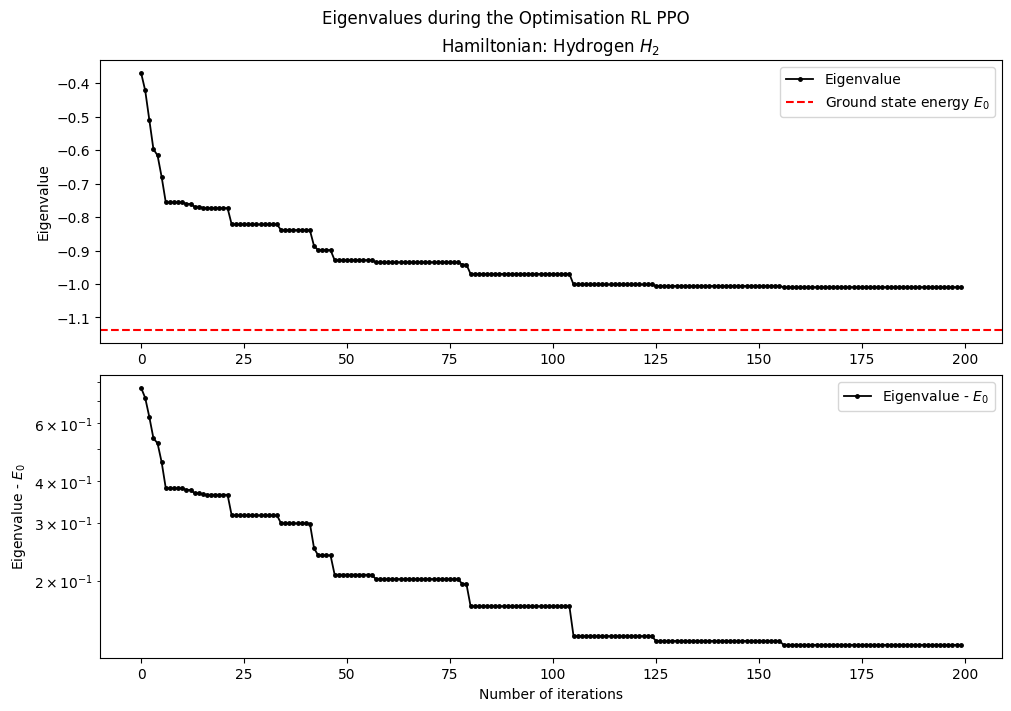

In [8]:
fig, ax = plt.subplots(2,1,figsize=(10,7), facecolor='white', constrained_layout = True, sharex=False, sharey=False)

plt.suptitle('Eigenvalues during the Optimisation RL PPO')
ax[0].set_title(r'Hamiltonian: Hydrogen $H_{2}$')
ax[0].plot(np.arange(n_total_timesteps), np.mean(metrics['history_best_eigenvalue_runs'],0), '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue')
ax[0].axhline(ground_state_energy, linestyle='--',color='r', label='Ground state energy $E_{0}$')

ax[1].plot(np.arange(n_total_timesteps), np.mean(metrics['history_best_eigenvalue_runs'],0) - ground_state_energy, '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue - $E_{0}$')
ax[1].set_yscale('log')
ax[0].set_ylabel('Eigenvalue')
ax[1].set_ylabel('Eigenvalue - $E_{0}$')
ax[1].set_xlabel('Number of iterations')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

plt.legend()
plt.show()

In [9]:
data_plot = {   'history_best_eigenvalue_runs':metrics['history_best_eigenvalue_runs'],
                'best_thetas_runs': metrics['best_thetas_runs'],
                'best_eigenvalue_runs':metrics['best_eigenvalue_runs'],
                'real_ground_state_energy':ground_state_energy,

            } 
if True:
    with open("../results/vqe/results_hamiltonian_hydrogen_H2_"+ str(num_qubits)+"qubits_ppo.json", "w") as outfile: 
        json.dump(data_plot, outfile, cls=CustomEncoder)

In [10]:
import mlflow
#Metrics resume
metrics_reg= {
    'mean_eigenvalue_runs': -np.mean(np.abs(metrics['best_eigenvalue_runs'])),
    'std_eigenvalue_runs': np.std(np.abs(metrics['best_eigenvalue_runs'])),
        }

params['size_final_dataset'] =  y_train.shape[0]

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VQE_H2")

with mlflow.start_run(run_name='VQE_H2_RL_PPO'):
    mlflow.log_params(params)
    mlflow.log_metrics(metrics_reg)
    

2024/09/29 14:59:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run VQE_H2_RL_PPO at: http://127.0.0.1:8080/#/experiments/839549506925561708/runs/6f197cc0df9445eb9c5cb24167aff95b.
2024/09/29 14:59:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/839549506925561708.
